In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import pandas as pd
import astropy as ap
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from datetime import datetime
import seaborn as sns
import scipy.stats as st

import histlite as hl
import csky as cy

from glob import glob
mpl.style.use('/home/apizzuto/Nova/python3/scripts/novae_plots.mplstyle')

## Do a single background distribution

In [5]:
greco_base = '/data/user/apizzuto/Nova/GRECO_Skylab_Dataset/v2.4/'

data_fs = sorted(glob(greco_base + 'IC86_20*data_with_angErr.npy'))
exp = [np.load(data) for data in data_fs]
exp = np.hstack(exp)
mc = np.load(greco_base + 'IC86_2012.numu_merged_with_angErr.npy')
grls = sorted(glob(greco_base + 'GRL/IC86_20*data.npy'))
grl = [np.load(g) for g in grls]
grl = np.hstack(grl)

greco = cy.selections.CustomDataSpecs.CustomDataSpec(exp, mc, np.sum(grl['livetime']), 
                                                     np.linspace(-1., 1., 31),
                                                     np.linspace(0., 4., 31), 
                                                     grl=grl, key='GRECOv2.4', cascades=True)

ana_dir = cy.utils.ensure_dir('/data/user/apizzuto/csky_cache/greco_ana')
greco_ana = cy.get_analysis(cy.selections.repo, greco, dir=ana_dir)

Setting up Analysis for:
GRECOv2.4
Setting up GRECOv2.4...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [6]:
master_df = pd.read_pickle('/home/apizzuto/Nova/master_nova_dataframe.pkl')
ras = master_df['RA']
decs = master_df['Dec']
names = master_df['Name']
delta_t = np.ones_like(ras)*0.1
mjds = np.array([t.mjd for t in master_df['Date']])

In [7]:
conf = {'extended': True,
       'space': "ps",
        'time': "transient",
        'sig': 'transient',
        #'energy': "customflux",
        #'flux': cy.hyp.PowerLawFlux(2),
       #'cut_n_sigma': 5.
       }

src = cy.utils.Sources(ra=np.radians(ras), 
                       dec=np.radians(decs), 
                       mjd=mjds, 
                       sigma_t=np.zeros_like(delta_t), 
                       t_100=delta_t)

cy.CONF['src'] = src
cy.CONF['mp_cpus'] = 10

tr = cy.get_trial_runner(conf, ana=greco_ana, src=src)
n_trials = 500
bg = cy.dists.Chi2TSD(tr.get_many_fits(n_trials))

Performing 500 background trials using 10 cores:
        500/500 trials complete.   


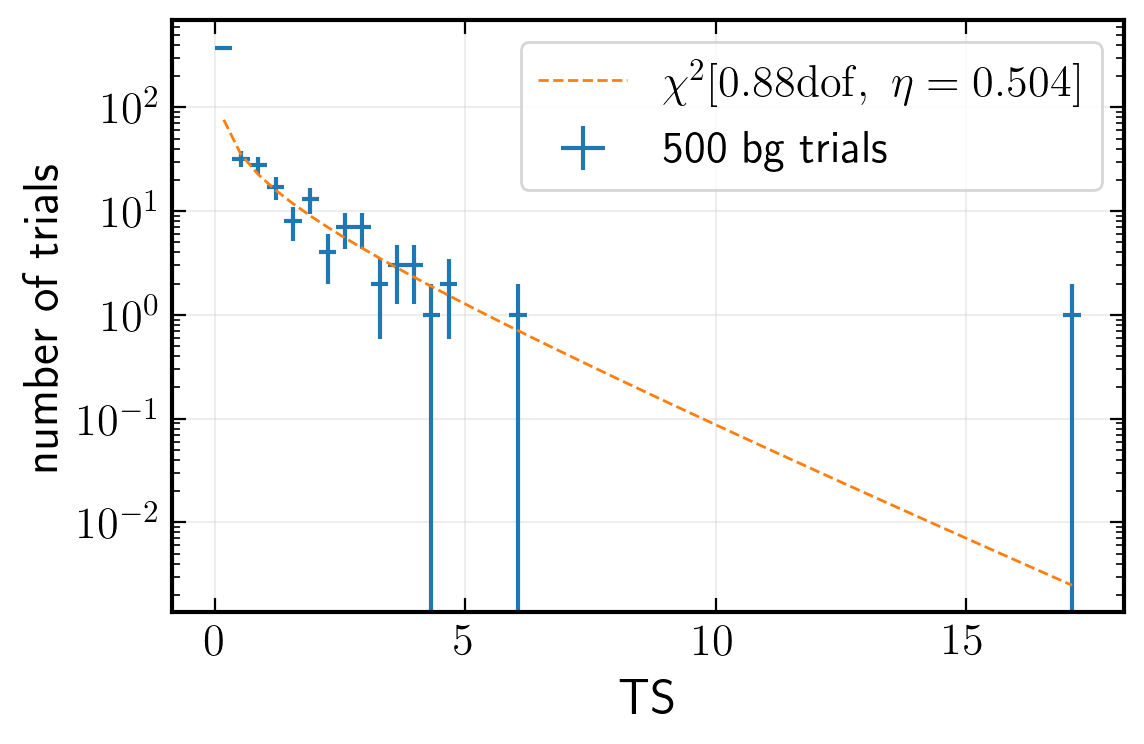

In [8]:
fig, ax = plt.subplots(dpi=200)

h = bg.get_hist(bins=50)
hl.plot1d(ax, h, crosses=True,
          label='{} bg trials'.format(bg.n_total))

x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
            label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
plt.tight_layout()

Performing 5000 background trials using 10 cores:
       5000/5000 trials complete.   


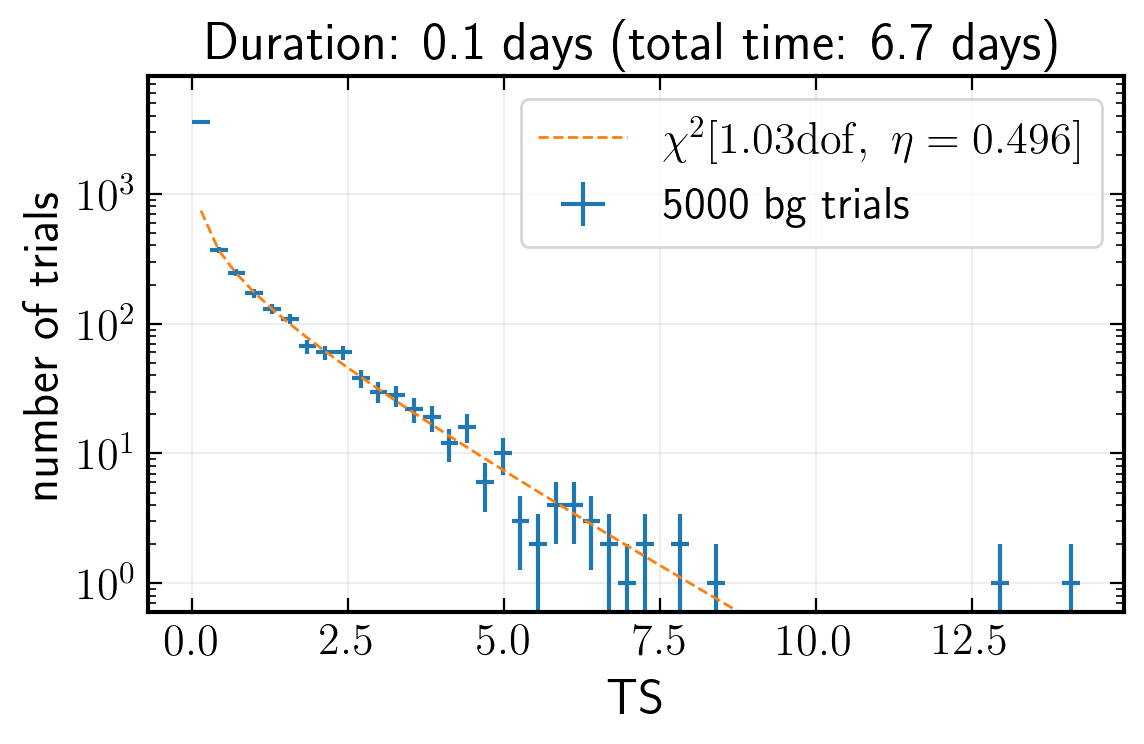

Performing 5000 background trials using 10 cores:
       5000/5000 trials complete.   


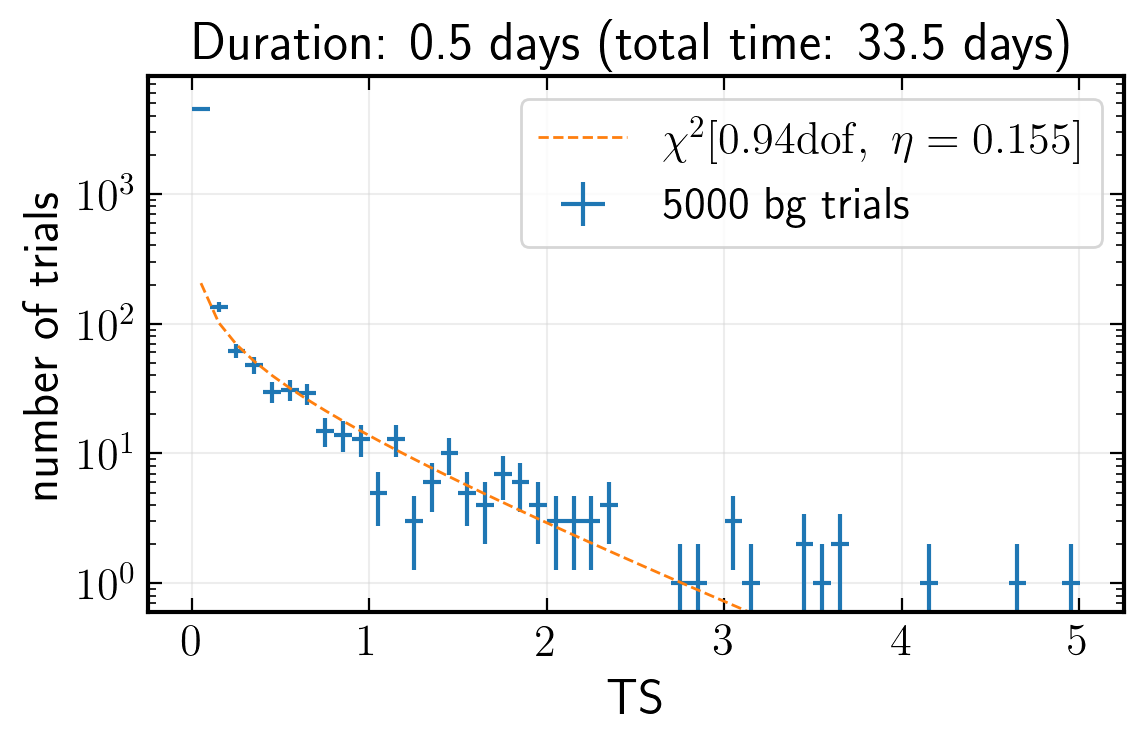

Performing 5000 background trials using 10 cores:
       5000/5000 trials complete.   


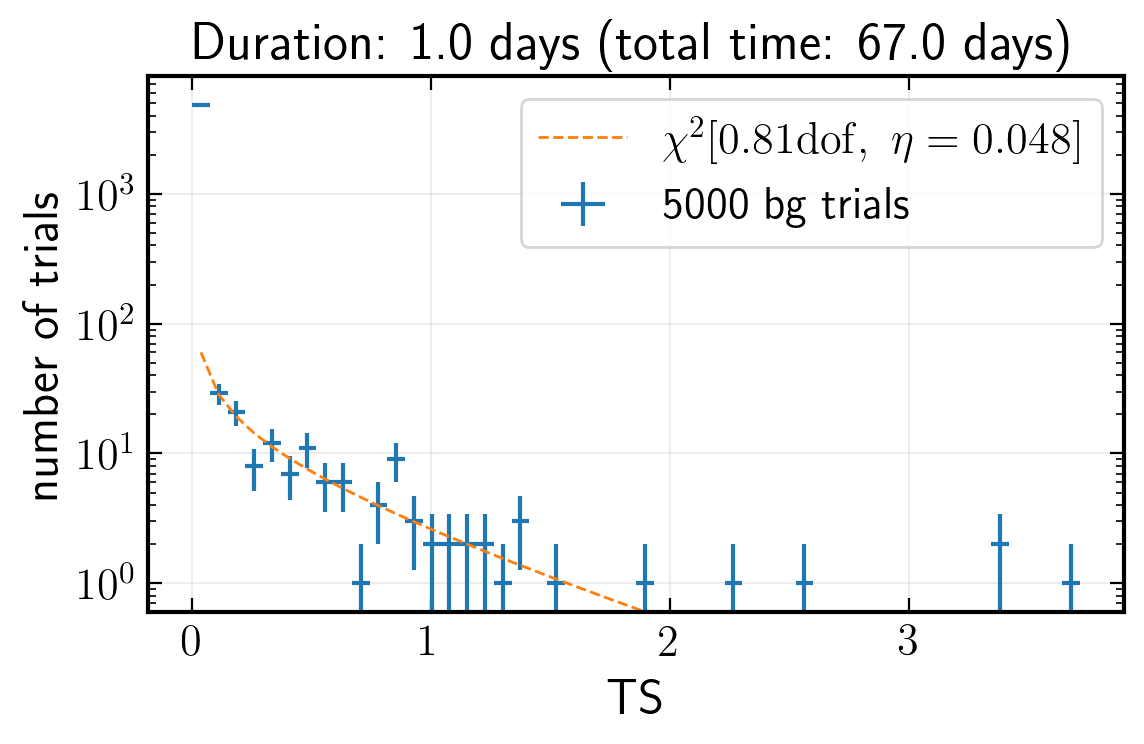

Performing 5000 background trials using 10 cores:
        143/5000 trials complete...
KeyboardInterrupt: terminating early.
        145/5000 trials complete.   


KeyboardInterrupt: 

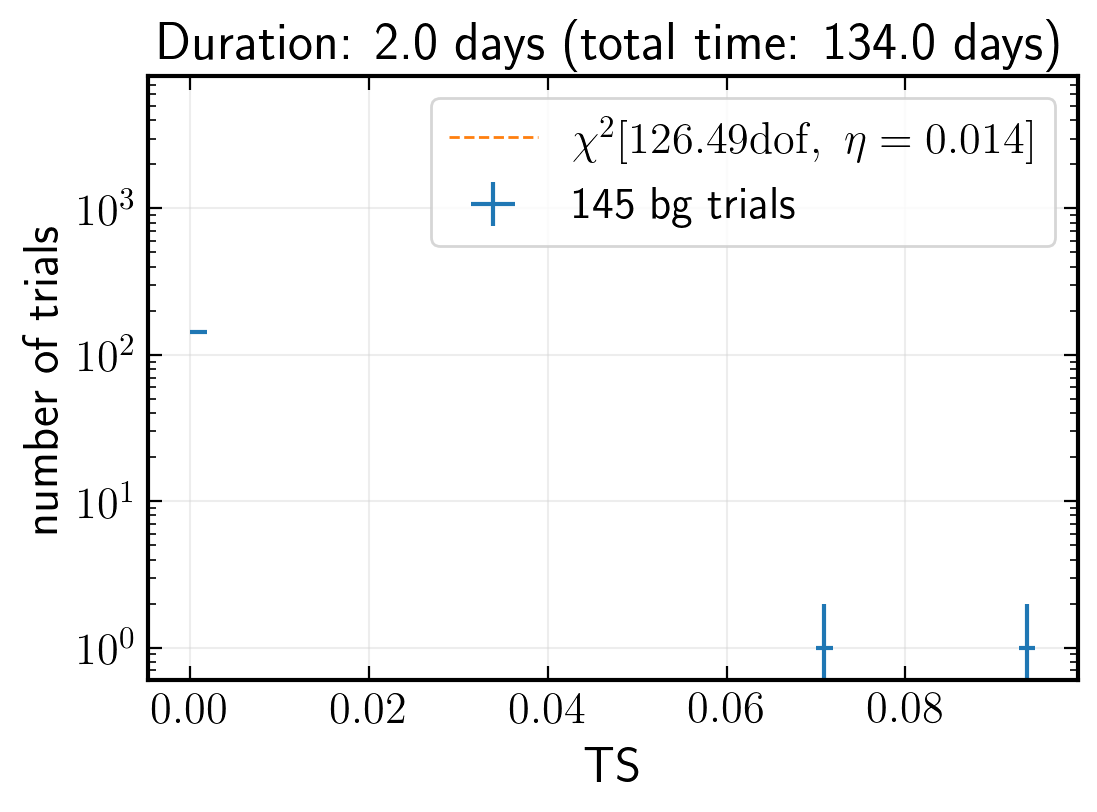

In [7]:
master_df = pd.read_pickle('/home/apizzuto/Nova/master_nova_dataframe.pkl')
ras = master_df['RA']
decs = master_df['Dec']
names = master_df['Name']
mjds = np.array([t.mjd for t in master_df['Date']])

for duration in [0.1, 0.5, 1.0, 2.0, 5.0, 14.]:
    delta_t = np.ones_like(ras)*duration
    conf = {'extended': True,
       'space': "ps",
        'time': "transient",
        'sig': 'transient',
        #'energy': "customflux",
        #'flux': cy.hyp.PowerLawFlux(2),
       #'cut_n_sigma': 5.
       }

    src = cy.utils.Sources(ra=np.radians(ras), 
                           dec=np.radians(decs), 
                           mjd=mjds, 
                           sigma_t=np.zeros_like(delta_t), 
                           t_100=delta_t)

    cy.CONF['src'] = src
    cy.CONF['mp_cpus'] = 10

    tr = cy.get_trial_runner(conf, ana=greco_ana, src=src)
    n_trials = 5000
    bg = cy.dists.Chi2TSD(tr.get_many_fits(n_trials))
    
    fig, ax = plt.subplots(dpi=200, figsize=(6,4))

    h = bg.get_hist(bins=50)
    hl.plot1d(ax, h, crosses=True,
              label='{} bg trials'.format(bg.n_total))

    x = h.centers[0]
    norm = h.integrate().values
    ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
                label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

    ax.set_xlabel(r'TS')
    ax.set_ylabel(r'number of trials')
    ax.set_ylim(6e-1, 8e3)
    ax.legend()
    ax.set_title(f"Duration: {duration:.1f} days (total time: {duration*len(ras):.1f} days)")
    plt.tight_layout()
    plt.show()

## Let's look at a likelihood scan. Coverage test?

In [11]:
inj_gamma = 2.0
inj_ns = 60

duration = 0.1
delta_t = np.ones_like(ras)*duration
src = cy.utils.Sources(ra=np.radians(ras), 
                           dec=np.radians(decs), 
                           mjd=mjds, 
                           sigma_t=np.zeros_like(delta_t), 
                           t_100=delta_t)

cy.CONF['src'] = src
cy.CONF['mp_cpus'] = 10

tr = cy.get_trial_runner(conf, ana=greco_ana, src=src, inj_conf={'flux': cy.hyp.PowerLawFlux(inj_gamma)})
trial = tr.get_one_trial(n_sig=inj_ns)
llh = tr.get_one_llh_from_trial(trial)
nss = np.linspace(0., 120., 100)
gammas = np.linspace(1., 4., 100)
llh_space = llh.scan_ts(ns=nss, gamma=gammas)
mesh_ns, mesh_gam = np.meshgrid(nss, gammas)
best_fit_ts = np.max(llh_space[0])
best_fit_ns = mesh_ns.flatten()[np.argmax(llh_space[0])]
best_fit_gamma = mesh_gam.flatten()[np.argmax(llh_space[0])]

          gamma
     4.0000e+00
Done.


In [12]:
chi2 = st.chi2(2., loc=0., scale=1)
crit_med = chi2.isf(0.5)
crit_90 = chi2.isf(1.0-0.9)
crit_99 = chi2.isf(1.0-0.99)

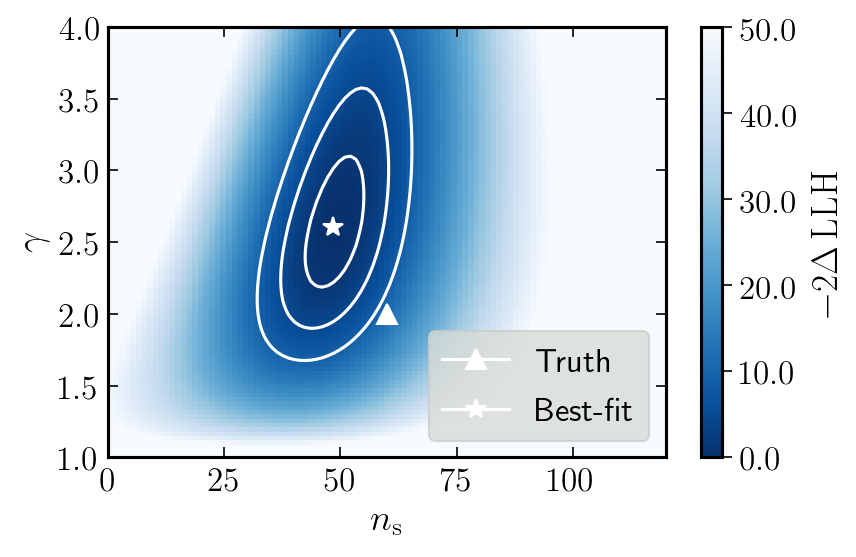

In [13]:
#X, Y = np.meshgrid(gammas, fluxnorm*1e3)
#matplotlib.rcParams["font.size"] = 20
fig, ax1 = plt.subplots(dpi=150)
ts_space = llh_space[0]

im = ax1.pcolor(mesh_ns, mesh_gam, -1.*(ts_space - best_fit_ts), cmap="Blues_r", vmin=0, vmax=50)#, norm=LogNorm(vmin=0.01, vmax=20))
ax_c = plt.colorbar(im, ax=ax1, format='$%.1f$')
ax_c.ax.tick_params(direction='out')
ax_c.set_label(r"$-2\Delta\,\mathrm{LLH}$")

#ax1.plot(best_fit[1]["gamma"],best_fit[1]["mu2flux"]*best_fit[1]["nsources"]*1e-5**best_fit[1]["gamma"]*1e3, marker="*", color="w", markersize=10 )
ax1.contour(mesh_ns, mesh_gam, -1.*(ts_space - best_fit_ts), 
            #levels=[1,4, 9, 16, 25], 
            levels=[crit_med, crit_90, crit_99], colors="w")
ax1.plot(inj_ns, inj_gamma, marker="^", color="w", markersize=10, label='Truth' )
ax1.plot(best_fit_ns, best_fit_gamma, marker="*", color="w", markersize=10, label='Best-fit')
ax1.set_ylabel(r"$\gamma$")
ax1.set_xlabel(r"$n_\mathrm{s}$")
#ax1.set_ylabel(r"$\Phi_{100\,\mathrm{TeV}}\,[\mathrm{TeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-1}] $")
ax1.legend(loc=4, facecolor=sns.xkcd_rgb['light grey'])

fig.tight_layout()

In [14]:
trial = tr.get_one_trial(n_sig=inj_ns)

In [16]:
tr.get_one_fit(n_sig=inj_ns)

[119.79869758483551, 91.76752935612473, 2.379730268667742]

In [17]:
trial = tr.get_one_fit(n_sig=inj_ns)

In [19]:
llh = tr.get_one_llh(n_sig=inj_ns)

In [24]:
llh.scan_ts(ns=0)

KeyError: 'gamma'

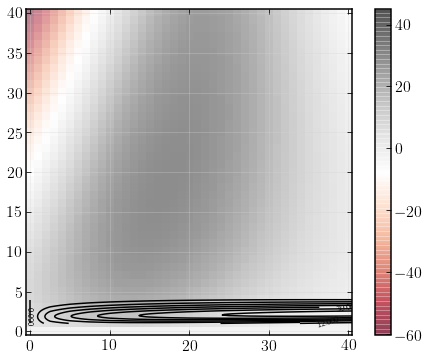

In [82]:
plt.figure(figsize=(8,6))
contours = plt.contour(llh_space[1][0], llh_space[1][1], llh_space[0], 20, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.imshow(llh_space[0], origin='lower', #extent=[0, 100., 1, 4], 
           cmap='RdGy', alpha=0.5)
plt.colorbar();

In [ ]:
plt.figure(figsize=(16,9))
plt.imshow(mapping,_
           aspect="auto",_
           extent=(gamma_bins[0],gamma_bins[-1],ns_bins[0],ns_bins[-1]),_
           interpolation="nearest",_
           origin="lower",_
           vmin=-map1_range,
           vmax=map1_range,_
           cmap="seismic")
plt.axhline(0, color="k", ls="--")
cb = plt.colorbar()
cb.set_label(r"$\Delta\log\mathcal{L}$")
plt.plot(params["gamma"],params["nsources"], marker="+", markersize=20, markeredgewidth=2, color="r")
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$n_s$")
plt.title(name)
plt.xlim(gamma_bins[0],gamma_bins[-1])
plt.ylim(ns_bins[0],ns_bins[-1])
plt.savefig("/net/scratch_icecube4/user/reimann/catalog_llh_landscape/LLH_landscape_{}_prior_width_{}.png".format(name, priorwidth))

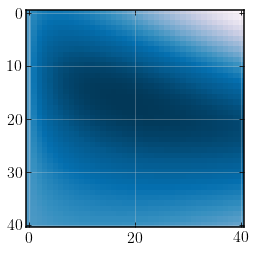

In [71]:
plt.imshow(llh_space[0].T)

In [57]:
tr.get_one_llh()

In [56]:
nss = np.linspace(0., 50., 21)
gammas = np.linspace(1., 4., 21)
mesh_ns, mesh_gams = np.meshgrid(nss, gammas)
llh.get_minus_llh_ratio(ns=mesh_ns.flatten(), gamma = mesh_gams.flatten())

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [55]:
len(mesh_gams.flatten())

441

## Fitting tests?

In [15]:
tr = cy.get_trial_runner(conf, ana=greco_ana, src=src, inj_conf={'flux': cy.hyp.PowerLawFlux(2.)})
trials = tr.get_many_fits(10, n_sig=100., logging=False, seed=1)

In [16]:
print(trials.ts, '\n', trials.ns, '\n', trials.gamma)

[40.78962557 40.19577874 59.07093277 49.58978017 47.33045671 38.58070561
 27.9496953  28.75001812 40.10632631 41.73668832] 
 [81.10898173 66.00580006 76.87119552 79.1438693  73.17449712 56.85706531
 55.07103282 53.30805395 81.18942649 89.51397083] 
 [2.11742885 1.76383505 1.81436305 1.98297385 1.78682425 1.97021526
 2.08104745 1.93047402 2.14206077 2.20621315]


In [33]:
tr.sig_injs[0].flux[0].gamma

2

In [ ]:
trials

In [18]:
n_sigs = np.r_[:101:10]

trials = [tr.get_many_fits(100, n_sig=n_sig, 
                           logging=False, 
                           seed=n_sig) for n_sig in n_sigs]

for (n_sig, t) in zip(n_sigs, trials):
    t['ntrue'] = np.repeat(n_sig, len(t))
allt = cy.utils.Arrays.concatenate(trials)

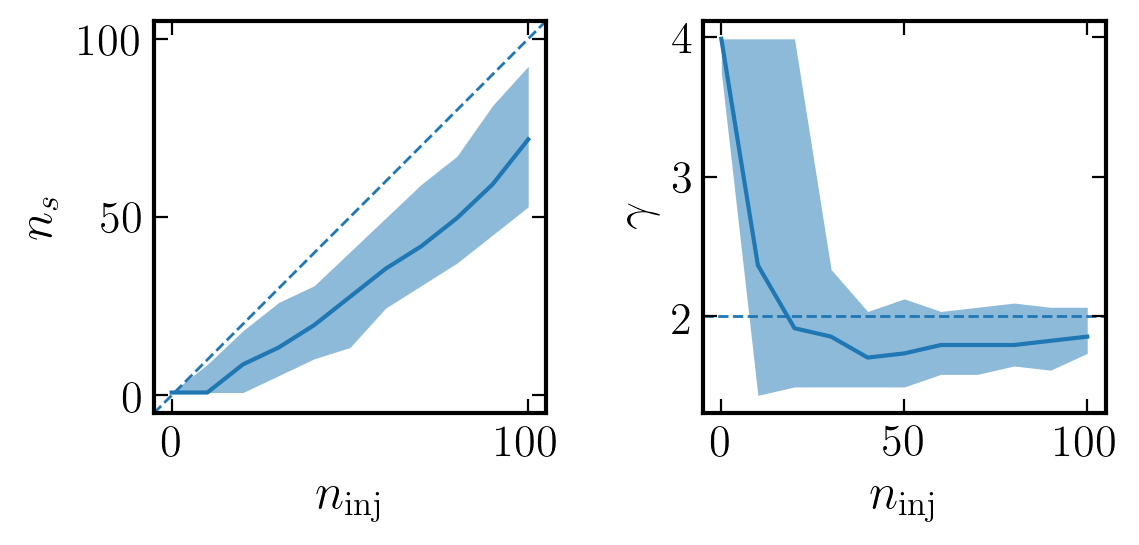

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(6,3), dpi=200)

dns = np.mean(np.diff(n_sigs))
ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
expect_gamma = tr.sig_injs[0].flux[0].gamma

ax = axs[0]
h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')

lim = ns_bins[[0, -1]]
ax.set_xlim(ax.set_ylim(lim))
ax.plot(lim, lim, **expect_kw)
ax.set_aspect('equal')


ax = axs[1]
h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
ax.axhline(expect_gamma, **expect_kw)
ax.set_xlim(axs[0].get_xlim())

for ax in axs:
    ax.set_xlabel(r'$n_\mathrm{inj}$')
    ax.grid()
axs[0].set_ylabel(r'$n_s$')
axs[1].set_ylabel(r'$\gamma$')

plt.tight_layout()

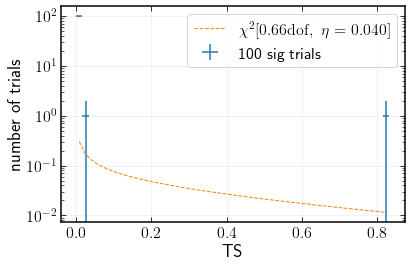

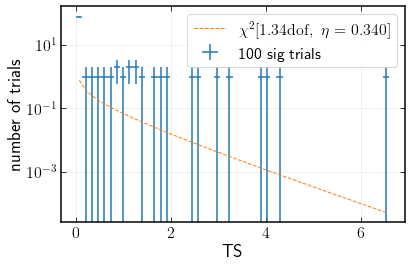

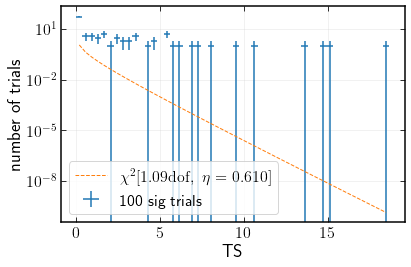

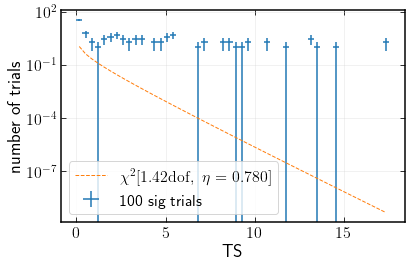

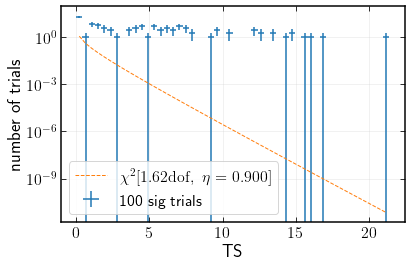

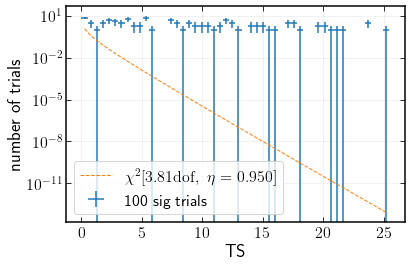

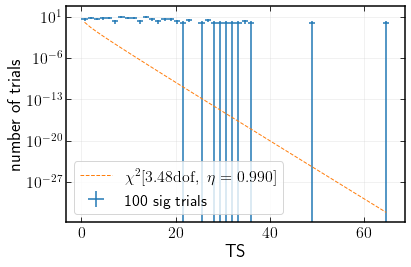

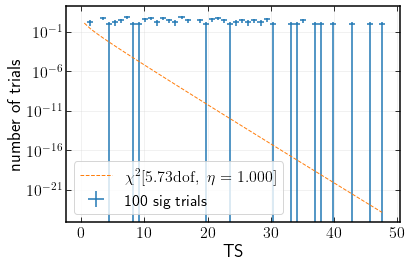

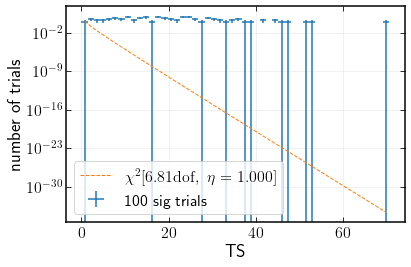

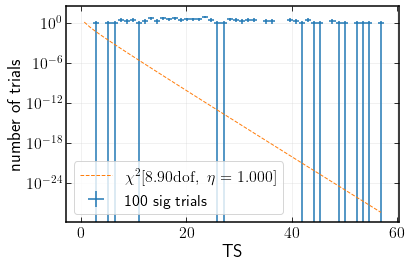

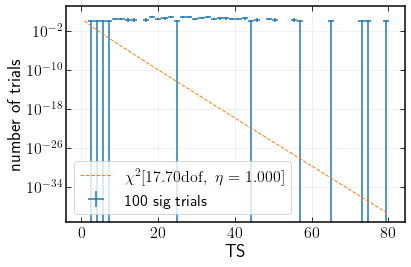

In [61]:
for trial in trials:
    fig, ax = plt.subplots()

    dist = cy.dists.Chi2TSD(trial)
    h = dist.get_hist(bins=50)
    hl.plot1d(ax, h, crosses=True,
              label='{} sig trials'.format(dist.n_total))

    x = h.centers[0]
    norm = h.integrate().values
    ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
                label=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$'.format(dist.ndof, dist.eta))

    ax.set_xlabel(r'TS')
    ax.set_ylabel(r'number of trials')
    ax.legend()
    plt.tight_layout()
    plt.show()

## Sensitivities